In [1]:
# Install TensorFlow
# !pip install -q tensorflow

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.2.0


In [0]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, \
  preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

# Load Data

In [3]:
# Data from: https://mmspg.epfl.ch/downloads/food-image-datasets/
# !wget --passive-ftp --prefer-family=ipv4 --ftp-user FoodImage@grebvm2.epfl.ch \
#  --ftp-password Cahc1moo -nc ftp://tremplin.epfl.ch/Food-5K.zip
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip

--2020-05-15 22:41:16--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.80.48, 104.31.81.48, 2606:4700:3035::681f:5130, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.80.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  11.2MB/s    in 44s     

2020-05-15 22:42:01 (9.73 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [0]:
!unzip -qq -o Food-5K.zip

In [5]:
!ls

Food-5K  Food-5K.zip  __MACOSX	sample_data


In [0]:
!mv Food-5K/* .

In [7]:
!ls training

0_0.jpg     0_1387.jpg	0_422.jpg  0_809.jpg   1_1195.jpg  1_230.jpg  1_617.jpg
0_1000.jpg  0_1388.jpg	0_423.jpg  0_80.jpg    1_1196.jpg  1_231.jpg  1_618.jpg
0_1001.jpg  0_1389.jpg	0_424.jpg  0_810.jpg   1_1197.jpg  1_232.jpg  1_619.jpg
0_1002.jpg  0_138.jpg	0_425.jpg  0_811.jpg   1_1198.jpg  1_233.jpg  1_61.jpg
0_1003.jpg  0_1390.jpg	0_426.jpg  0_812.jpg   1_1199.jpg  1_234.jpg  1_620.jpg
0_1004.jpg  0_1391.jpg	0_427.jpg  0_813.jpg   1_119.jpg   1_235.jpg  1_621.jpg
0_1005.jpg  0_1392.jpg	0_428.jpg  0_814.jpg   1_11.jpg    1_236.jpg  1_622.jpg
0_1006.jpg  0_1393.jpg	0_429.jpg  0_815.jpg   1_1200.jpg  1_237.jpg  1_623.jpg
0_1007.jpg  0_1394.jpg	0_42.jpg   0_816.jpg   1_1201.jpg  1_238.jpg  1_624.jpg
0_1008.jpg  0_1395.jpg	0_430.jpg  0_817.jpg   1_1202.jpg  1_239.jpg  1_625.jpg
0_1009.jpg  0_1396.jpg	0_431.jpg  0_818.jpg   1_1203.jpg  1_23.jpg   1_626.jpg
0_100.jpg   0_1397.jpg	0_432.jpg  0_819.jpg   1_1204.jpg  1_240.jpg  1_627.jpg
0_1010.jpg  0_1398.jpg	0_433.jpg  0_81.jpg    1_1205.j

# Exploratory Data Analysis

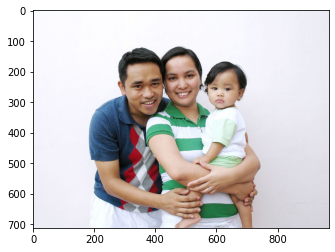

In [8]:
# Non-food image
plt.imshow(image.load_img('training/0_421.jpg'))

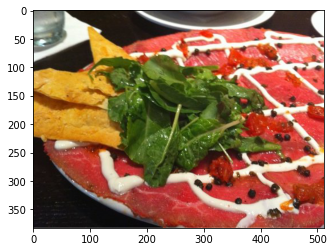

In [9]:
# Food image
plt.imshow(image.load_img('training/1_421.jpg'))

# Data Preprocessing

In [0]:
!mkdir data

In [0]:
# Make directories to store the data Keras-style
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [0]:
# Move the images
# Note: we will consider 'training' to be the train set
#       'validation' folder will be the test set
#       ignore the 'evaluation' set
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [0]:
train_path = 'data/train'
test_path = 'data/test'

In [0]:
# Reshape images
IMAGE_SIZE = [200, 200]

In [0]:
num_train_image_files = glob(train_path + '/*/*.jpg')
num_test_image_files = glob(test_path + '/*/*.jpg')

In [16]:
# Get number of classes
folders = glob(train_path + '/*')
folders

['data/train/nonfood', 'data/train/food']

# Build Model

In [17]:
ptm = PretrainedModel(input_shape = IMAGE_SIZE + [3], # 3 mode color channel
                      weights = 'imagenet',
                      include_top=False) # Transfer learning with imagenet by using its bottom part

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
# freeze pretrained model weights
ptm.trainable = False

In [0]:
# Mapping data to feature vectors
K = len(folders) # number of classes
x = Flatten()(ptm.output)

In [0]:
model = Model(inputs = ptm.input, outputs = x)

In [27]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0   

# Create Generators

In [0]:
# Create ImageDataGenerator
image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)



In [0]:
batch_size = 128

In [40]:
# Create generator
train_generator = image_generator.flow_from_directory(
    train_path,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    class_mode = 'binary',
)

test_generator = image_generator.flow_from_directory(
    test_path,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    class_mode = 'binary',
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Create Train and Test Arrays

In [0]:
N_train = len(num_train_image_files)
N_test = len(num_test_image_files)

In [0]:
# Determine output size
feat = model.predict(np.random.random([1] + IMAGE_SIZE + [3]))
D = feat.shape[1]


In [0]:
X_train = np.zeros((N_train, D))
y_train = np.zeros(N_train)
X_test = np.zeros((N_test, D))
y_test = np.zeros((N_test))

## Populate X_train and y_train

In [47]:
i = 0 # sample index
for x, y in train_generator:
  # Get features
  feat = model.predict(x)

  current_batch_size = len(y)

  X_train[i:i + current_batch_size] = feat
  y_train[i:i + current_batch_size] = y

  i += current_batch_size

  print(i)

  if i >= N_train:
    break;

128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2616
2744
2872
3000


In [49]:
if (i == N_train):
  print("Correct number of train images populated")

Correct number of train images populated


In [52]:
i = 0 # sample index
for x, y in test_generator:
  # Get features
  feat = model.predict(x)

  current_batch_size = len(y)

  X_test[i:i + current_batch_size] = feat
  y_test[i:i + current_batch_size] = y

  i += current_batch_size
  print(i)

  if i >= N_test:
    break;
  

128
256
384
512
640
768
896
1000


In [53]:
if (i == N_test):
  print("Correct number of test images populated")

Correct number of test images populated


# Check Performance of Sklearn Logistic Regression

## Normalize Data

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Build Logistic Regression Model

In [99]:
from sklearn.linear_model import LogisticRegression
model_logreg = LogisticRegression()
model_logreg.fit(X_train_scaled, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Evaluate Logistic Regression Model

In [100]:
print("Train Accuracy: ", model_logreg.score(X_train_scaled, y_train))
print("Test Accuracy: ", model_logreg.score(X_test_scaled, y_test))

Train Accuracy:  1.0
Test Accuracy:  0.98


# Check Tensorflow Logistic Regression

## Build Logistic Regression Model

In [0]:
i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)

linearModel = Model(i, x)

linearModel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [94]:
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(3000, 18432)
(3000,)
(1000, 18432)
(1000,)
(3000, 18432)
(3000,)
(1000, 18432)
(1000,)


In [101]:
print(linearModel.summary())

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 18432)]           0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 18433     
Total params: 18,433
Trainable params: 18,433
Non-trainable params: 0
_________________________________________________________________
None


In [95]:
r = linearModel.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=15,
    validation_data=(X_test, y_test),
)

Epoch 1/15
24/24 [==============================] - 0s 11ms/step - loss: 0.8296 - accuracy: 0.9323 - val_loss: 0.2561 - val_accuracy: 0.9750
Epoch 2/15
24/24 [==============================] - 0s 9ms/step - loss: 0.0496 - accuracy: 0.9943 - val_loss: 0.2881 - val_accuracy: 0.9760
Epoch 3/15
24/24 [==============================] - 0s 9ms/step - loss: 0.0051 - accuracy: 0.9990 - val_loss: 0.3603 - val_accuracy: 0.9750
Epoch 4/15
24/24 [==============================] - 0s 9ms/step - loss: 8.5940e-04 - accuracy: 0.9997 - val_loss: 0.3736 - val_accuracy: 0.9750
Epoch 5/15
24/24 [==============================] - 0s 9ms/step - loss: 1.0469e-06 - accuracy: 1.0000 - val_loss: 0.3214 - val_accuracy: 0.9780
Epoch 6/15
24/24 [==============================] - 0s 9ms/step - loss: 8.3779e-07 - accuracy: 1.0000 - val_loss: 0.3178 - val_accuracy: 0.9780
Epoch 7/15
24/24 [==============================] - 0s 9ms/step - loss: 8.4031e-07 - accuracy: 1.0000 - val_loss: 0.3176 - val_accuracy: 0.9780
Epo

## Evaluate Logistic Regression Model

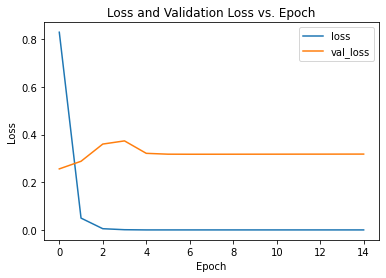

In [96]:
# Plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title("Loss and Validation Loss vs. Epoch")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

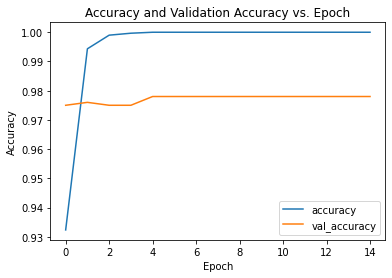

In [97]:
# Plot the accuracy
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title("Accuracy and Validation Accuracy vs. Epoch")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()